# import Libraries

In [2]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array, load_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.models import load_model

# Load Dataset

In [3]:
train_dir = '/home/anna/kaggle/train_images'
test_dir = '/home/anna/kaggle/test_images'
train_data = pd.read_csv('/home/anna/kaggle/train.csv')
test_data = pd.read_csv('/home/anna/kaggle/test.csv')

In [8]:
from tqdm import tqdm
train=[]
trainlabel=[]
for im in tqdm(os.listdir(train_dir)):
    image=load_img(os.path.join(train_dir,im), grayscale=False, color_mode='rgb', target_size=(224,224))
    image=img_to_array(image)
    image=image/255.0
    train+=[image]
    trainlabel+=[train_data[train_data['id_code']==im[0:-4]]['diagnosis'].iat[0]]

100%|██████████| 3662/3662 [07:50<00:00,  7.79it/s]


In [9]:
test=[]
for im in tqdm(os.listdir(test_dir)):
    image=load_img(os.path.join(test_dir,im), grayscale=False, color_mode='rgb', target_size=(224,224))
    image=img_to_array(image)
    image=image/255.0
    test+=[image]

100%|██████████| 1928/1928 [01:20<00:00, 23.86it/s]


# Visualization
- histogram of frequency 
- pie plot of frequency of classes in the individual subset - stratified split 
- displey some images - sample

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


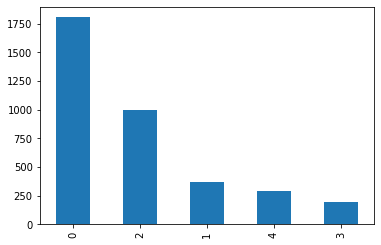

In [4]:
train_data.diagnosis.value_counts().plot(kind="bar")
train_data.head()

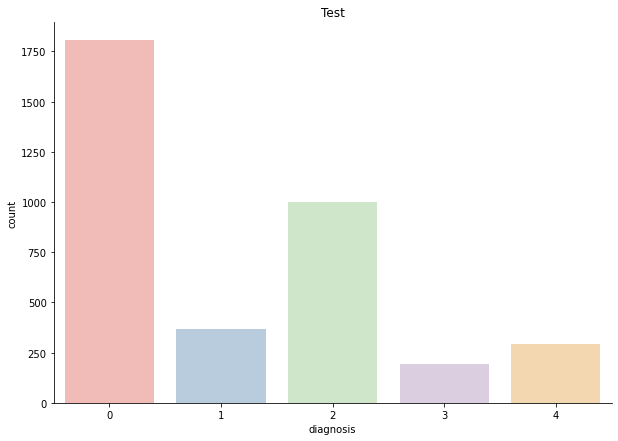

In [5]:
fig = plt.subplots(sharex='col', figsize=(10, 7))
sns.countplot(x="diagnosis", data=train_data, palette="Pastel1").set_title('Test')
sns.despine()
plt.show()

- pie plot of frequency of classes in the individual subset - stratified split
Stratified sampling aims at splitting a data set so that each split is similar with respect to something. In a classification setting, it is often chosen to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set

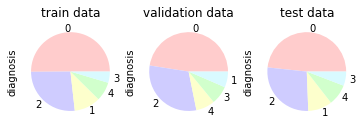

In [6]:
X_tt, X_ttest = train_test_split(train_data, test_size=0.3)
X_ttrain, X_vval = train_test_split(X_tt, test_size=0.15)

colors = ['#ffcccc','#cfccff','#fdffcc','#d1ffcc', '#d9faff']
fig, axes = plt.subplots(nrows=1, ncols=3)
X_ttrain.diagnosis.value_counts().plot(kind="pie", ax=axes[0],title="train data", colors= colors)
X_vval.diagnosis.value_counts().plot(kind="pie", ax=axes[1], title="validation data", colors= colors)
X_ttest.diagnosis.value_counts().plot(kind="pie", ax=axes[2], title="test data", colors= colors)

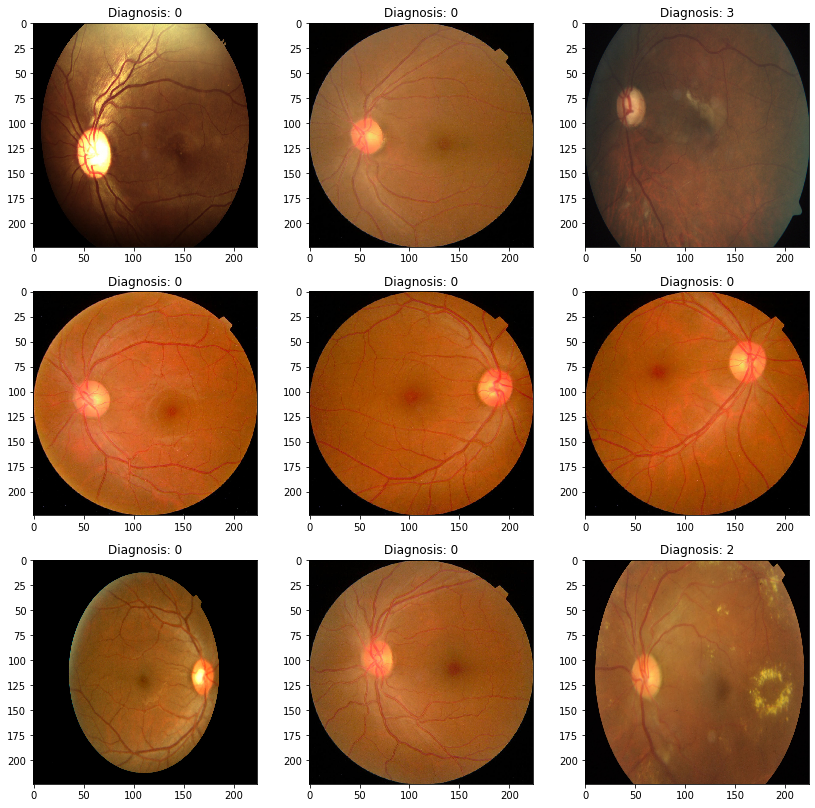

In [10]:
fig,axs = plt.subplots(3,3,figsize=(14,14))
for i in range(9):
    r=i//3
    c=i%3
    ax=axs[r][c].imshow(train[i])
    ax=axs[r][c].set_title('Diagnosis: '+str(trainlabel[i]))    
plt.show()

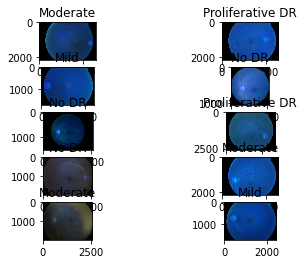

In [11]:
# Display some images
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]

figure, ax = plt.subplots(5,2)
ax = ax.flatten()
for i,row in train_data.iloc[0:10,:].iterrows():
    ax[i].imshow(cv2.imread(os.path.join("/home/anna/kaggle/train_images",row["id_code"]+".png")))
    ax[i].set_title(label_title[str(row["diagnosis"])])

# Preprocess

In [12]:
train=np.array(train)
trainlabel=np.array(trainlabel)
test=np.array(test)

print(train.shape)
print(trainlabel.shape)
print(test.shape)

(3662, 224, 224, 3)
(3662,)
(1928, 224, 224, 3)


In [13]:
# label enconding of labels in training set
trainlabel2=to_categorical(trainlabel)

In [14]:
# split dataset into train and test set
x_train,x_test,y_train,y_test=train_test_split(train,trainlabel2,test_size=0.2,random_state=44)


In [15]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2929, 224, 224, 3)
(733, 224, 224, 3)
(2929, 5)
(733, 5)


# Apply Data Augmentation on Train Set

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                              rotation_range=20,
                              zoom_range=0.2,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.1,
                              fill_mode="nearest")

# Build Model

In [17]:
from keras.layers import BatchNormalization
np.random.seed(1000)
num_classes = 5
#Instantiation
model = Sequential()

#1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(32,32,3,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

#2nd Fully Connected Layer
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
#Add Dropout
model.add(Dropout(0.4))

#3rd Fully Connected Layer
model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation('relu'))
#Add Dropout
model.add(Dropout(0.4))

#Output Layer
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

## Model information
- summary information of model
- plot model


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0

## Training model

    - optimizer: Adam
    - loss: categorical crossentropy
    - epochs: 20
    - chcekpoint: minimum val_loss
    - batch size: 16

In [23]:
model.compile(optimizer = Adam(learning_rate = 0.0001),loss = 'categorical_crossentropy', metrics = ['accuracy']) # use lr instead of learning_rate if error occurs

saved_model = 'model2_acc.hdf5'
checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

epochs = 20
batch_size = 16 # check with 32
history = model.fit(datagen.flow(x_train,y_train,batch_size=batch_size),validation_data=(x_test,y_test),epochs=20, callbacks = [checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
184/184 [==============================] - 565s 3s/step - loss: 1.4566 - accuracy: 0.4329 - val_loss: 4.2318 - val_accuracy: 0.1078

Epoch 00001: val_accuracy improved from -inf to 0.10778, saving model to model2_acc.hdf5
Epoch 2/20
184/184 [==============================] - 541s 3s/step - loss: 1.1564 - accuracy: 0.5885 - val_loss: 3.6010 - val_accuracy: 0.1187

Epoch 00002: val_accuracy improved from 0.10778 to 0.11869, saving model to model2_acc.hdf5
Epoch 3/20
184/184 [==============================] - 541s 3s/step - loss: 1.1382 - accuracy: 0.5860 - val_loss: 1.8997 - val_accuracy: 0.2333

Epoch 00003: val_accuracy improved from 0.11869 to 0.23329, saving model to model2_acc.hdf5
Epoch 4/20
184/184 [==============================] - 539s 3s/step - loss: 1.1162 - accuracy: 0.6147 - val_loss: 1.2317 - val_accuracy: 0.5580

Epoch 00004: val_accuracy improved from 0.23329 to 0.55798, saving model to model2_acc.hdf5
Epoch 5/20
184/184 [==============================] - 541s 

#### PLOT: training process
    - we use ModelCheckpoint -> saved model with the max validation accuracy 

In [24]:
def trainingProcess(history):
    plt.style.use('ggplot')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

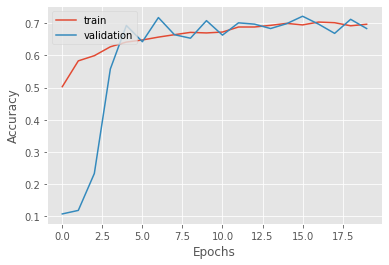

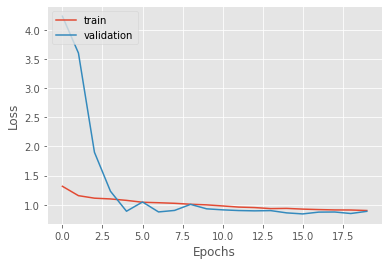

In [25]:
trainingProcess(history)

# Model Prediction and Evaluation

In [26]:
# load best model
myModel = load_model('/home/anna/kaggle/model2_acc.hdf5') 

In [27]:
# evaluate performance of trained model on test data
evaluation = myModel.evaluate(x_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

23/23 [==============================] - 21s 850ms/step - loss: 0.8435 - accuracy: 0.7217
Test Accuracy : 72.17%


In [28]:
# make prediction of trained model on test data
pred = myModel.predict(x_test)
y_pred = np.argmax(pred,axis =1)
y_test=np.argmax(y_test, axis=1)

In [29]:
pred2=myModel.predict(test)
print(test.shape)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]

(1928, 224, 224, 3)
(1928, 5)


# Print Confusion Matrix

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization


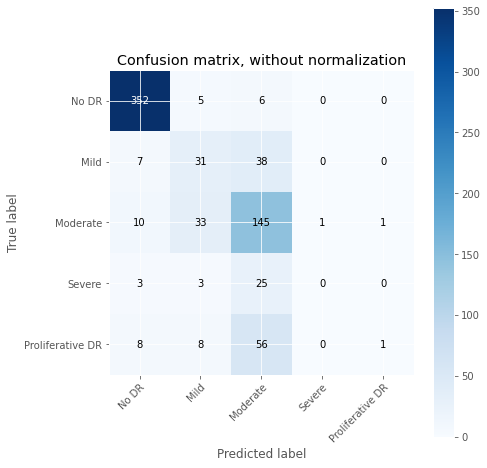

In [31]:
plot_confusion_matrix(y_test, y_pred, classes= np.array(class_labels))


# Print Classification Report

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       363
           1       0.39      0.41      0.40        76
           2       0.54      0.76      0.63       190
           3       0.00      0.00      0.00        31
           4       0.50      0.01      0.03        73

    accuracy                           0.72       733
   macro avg       0.47      0.43      0.40       733
weighted avg       0.69      0.72      0.68       733

